In [1]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-02-27 07:54:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  35.3MB/s    in 14s     

2024-02-27 07:54:55 (34.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [2]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [3]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have train_data and test_data prepared already

# Create our model (a clone of model_8, except to be multi-class)
model_1 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(64, activation='relu'),  # Adding a Dense layer with ReLU activation
    Dropout(0.5),  # Adding a dropout layer with a dropout rate of 0.5
    Dense(10, activation='softmax')  # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_1.compile(loss="categorical_crossentropy",  # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Stop training when validation loss doesn't improve for 3 epochs

history_1 = model_1.fit(train_data,  # now 10 different classes
                        epochs=50,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[ early_stopping])  # including lr_scheduler


Epoch 1/50
235/235 [==============================] - 37s 146ms/step - loss: 2.3255 - accuracy: 0.1205 - val_loss: 2.2206 - val_accuracy: 0.1644
Epoch 2/50
235/235 [==============================] - 33s 139ms/step - loss: 2.2247 - accuracy: 0.1460 - val_loss: 2.1778 - val_accuracy: 0.1776
Epoch 3/50
235/235 [==============================] - 31s 133ms/step - loss: 2.2007 - accuracy: 0.1560 - val_loss: 2.1674 - val_accuracy: 0.2048
Epoch 4/50
235/235 [==============================] - 31s 132ms/step - loss: 2.1679 - accuracy: 0.1736 - val_loss: 2.1282 - val_accuracy: 0.1980
Epoch 5/50
235/235 [==============================] - 31s 133ms/step - loss: 2.1314 - accuracy: 0.1848 - val_loss: 2.0948 - val_accuracy: 0.2324
Epoch 6/50
235/235 [==============================] - 32s 138ms/step - loss: 2.0822 - accuracy: 0.2057 - val_loss: 2.0945 - val_accuracy: 0.2320
Epoch 7/50
235/235 [==============================] - 32s 136ms/step - loss: 2.0190 - accuracy: 0.2248 - val_loss: 2.0968 - val_ac

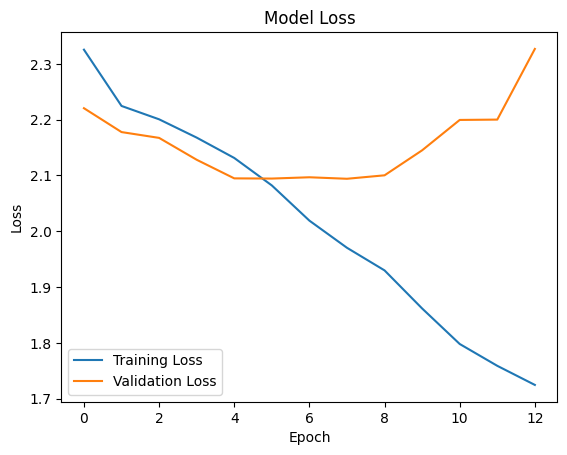

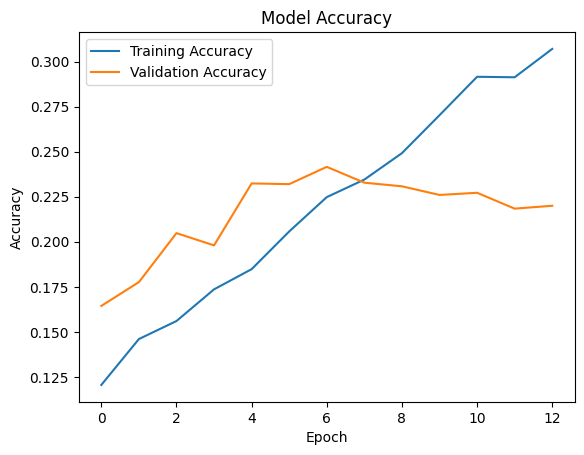

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [19]:
train_pred = model_1.predict(train_data)
valid_pred = model_1.predict(test_data)

# Convert predictions to binary classes
train_pred_classes = np.round(train_pred)
valid_pred_classes = np.round(valid_pred)

# Get true labels
train_true = train_data.classes
valid_true = test_data.classes


import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics for training set
train_accuracy = accuracy_score(train_true, train_pred_classes)
train_precision = precision_score(train_true, train_pred_classes)
train_recall = recall_score(train_true, train_pred_classes)
train_f1 = f1_score(train_true, train_pred_classes)

# Calculate metrics for validation set
valid_accuracy = accuracy_score(valid_true, valid_pred_classes)
valid_precision = precision_score(valid_true, valid_pred_classes)
valid_recall = recall_score(valid_true, valid_pred_classes)
valid_f1 = f1_score(valid_true, valid_pred_classes)

# Create a dataframe
metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation'],
    'Accuracy': [train_accuracy, valid_accuracy],
    'Precision': [train_precision, valid_precision],
    'Recall': [train_recall, valid_recall],
    'F1-score': [train_f1, valid_f1]
})

print(metrics_df)


import seaborn as sns
import matplotlib.pyplot as plt
valid_confusion_matrix = confusion_matrix(valid_true, valid_pred_classes)

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(valid_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Steak', 'Pizza'], yticklabels=['Steak', 'Pizza'])
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Create a dataframe for confusion matrix
confusion_matrix_df = pd.DataFrame(valid_confusion_matrix, columns=['Predicted Steak', 'Predicted Pizza'],
                                   index=['Actual Steak', 'Actual Pizza'])
print("\nConfusion Matrix - Validation Set:")
print(confusion_matrix_df)

79/79 [==============================] - 8s 95ms/step


ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [16]:
model_1.evaluate(test_data)

79/79 [==============================] - 9s 110ms/step - loss: 2.3269 - accuracy: 0.2200


[2.3268826007843018, 0.2199999988079071]

In [20]:
model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
   Dropout(0.5),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
   Dropout(0.5),
  Flatten(),
  Dropout(0.5),
  Dense(10, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Stop training when validation loss doesn't improve for 3 epochs


history_2= model_2.fit(train_data,
                          epochs=50,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                         callbacks = [early_stopping])


Epoch 1/50
235/235 [==============================] - 37s 150ms/step - loss: 2.2414 - accuracy: 0.1597 - val_loss: 2.1901 - val_accuracy: 0.1956
Epoch 2/50
235/235 [==============================] - 31s 132ms/step - loss: 2.0476 - accuracy: 0.2736 - val_loss: 2.0586 - val_accuracy: 0.2828
Epoch 3/50
235/235 [==============================] - 34s 143ms/step - loss: 1.9069 - accuracy: 0.3364 - val_loss: 2.0065 - val_accuracy: 0.3088
Epoch 4/50
235/235 [==============================] - 33s 139ms/step - loss: 1.8180 - accuracy: 0.3728 - val_loss: 1.9350 - val_accuracy: 0.3304
Epoch 5/50
235/235 [==============================] - 31s 133ms/step - loss: 1.7332 - accuracy: 0.4011 - val_loss: 1.9505 - val_accuracy: 0.3096
Epoch 6/50
235/235 [==============================] - 30s 127ms/step - loss: 1.6519 - accuracy: 0.4416 - val_loss: 1.9028 - val_accuracy: 0.3504
Epoch 7/50
235/235 [==============================] - 35s 149ms/step - loss: 1.5710 - accuracy: 0.4609 - val_loss: 1.9160 - val_ac

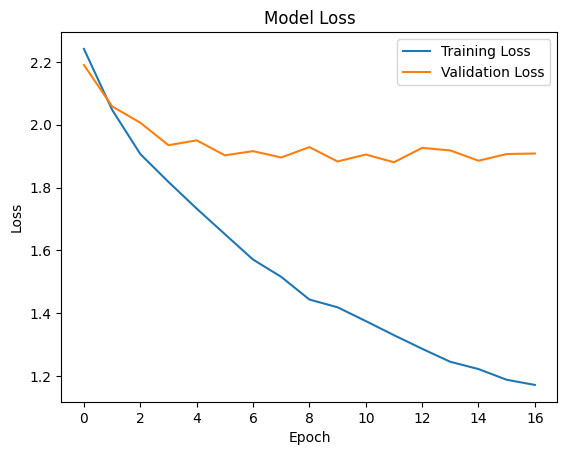

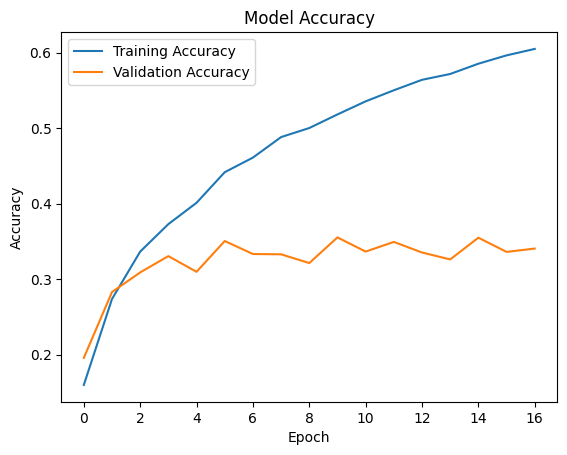

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [23]:
test_data.classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [32]:
# Convert probabilities to class labels
train_pred_classes = np.argmax(train_pred, axis=1)
valid_pred_classes = np.argmax(valid_pred, axis=1)

# Calculate metrics for training set
train_accuracy = accuracy_score(train_true, train_pred_classes, )
train_precision = precision_score(train_true, train_pred_classes,average = "macro")
train_recall = recall_score(train_true, train_pred_classes,average = "macro")
train_f1 = f1_score(train_true, train_pred_classes, average = "macro")

# Calculate metrics for validation set
valid_accuracy = accuracy_score(valid_true, valid_pred_classes)
valid_precision = precision_score(valid_true, valid_pred_classes, average = "macro")
valid_recall = recall_score(valid_true, valid_pred_classes, average = "macro")
valid_f1 = f1_score(valid_true, valid_pred_classes, average = "macro")

metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation'],
    'Accuracy': [train_accuracy, valid_accuracy],
    'Precision': [train_precision, valid_precision],
    'Recall': [train_recall, valid_recall],
    'F1-score': [train_f1, valid_f1]
})

print(metrics_df)



      Dataset  Accuracy  Precision    Recall  F1-score
0    Training  0.097733   0.096690  0.097733  0.096069
1  Validation  0.104400   0.104089  0.104400  0.100960


Shapes:
train_true: (7500,)
train_pred_classes: (7500, 10)
valid_true: (2500,)
valid_pred_classes: (2500, 10)

Sample values:
train_true: [0 0 0 0 0 0 0 0 0 0]
train_pred_classes: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
valid_true: [0 0 0 0 0 0 0 0 0 0]
valid_pred_classes: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [28]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 10)      0         
                                                                 
 conv2d_29 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 54, 54, 10)       